/Users/ruo/Desktop/codestates/CP2-backup/preprocess.py:86: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  items_stack = pd.DataFrame(templates['items'].apply(lambda x: pd.Series(x)).stack()).reset_index(1, drop=True)


사용자가 선택한 아이템 : 카메론 3인용 스타일클린 워셔블 패브릭소파


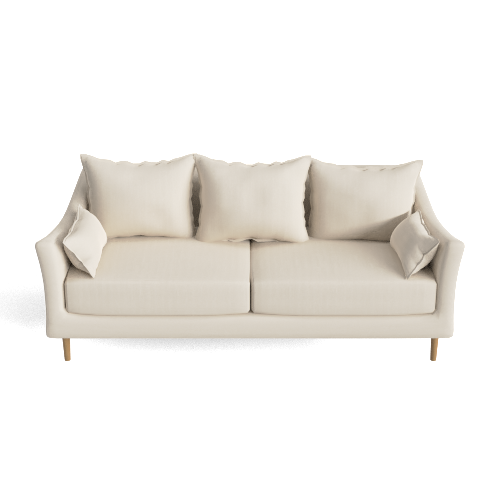

추천 아이템 Top14
추천 1순위 : LED 레이1등 펜던트_2colors (투명유리/블랙) (노란불빛)


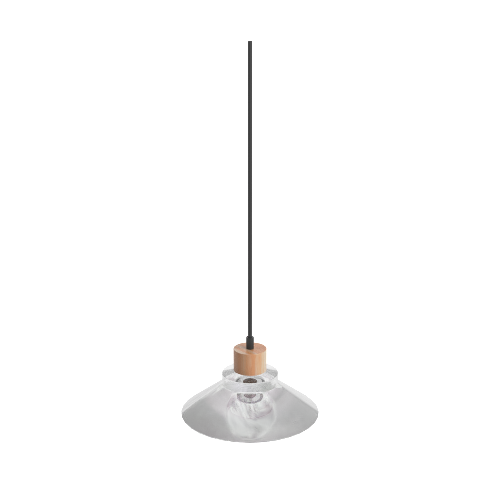

------------------------------------------------------------
추천 2순위 : 임스 몰디드 플라스틱 암체어 DAX (스톤)


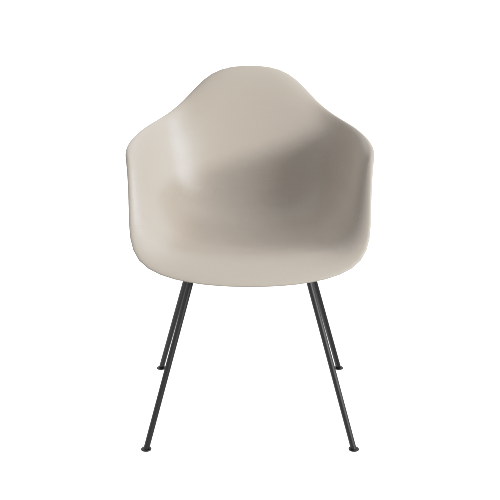

------------------------------------------------------------
추천 3순위 : 네온 팝 원형 러그 150cm (주황)


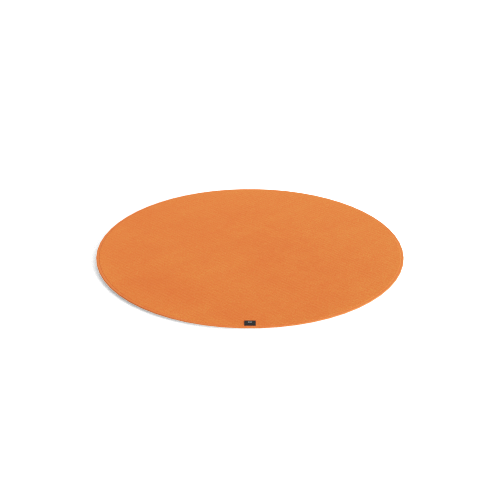

------------------------------------------------------------
추천 4순위 : 명화 빈티지 전시회 포스터 - 윌리엄 모리스 윌로우 (포스터만) (50x70cm)


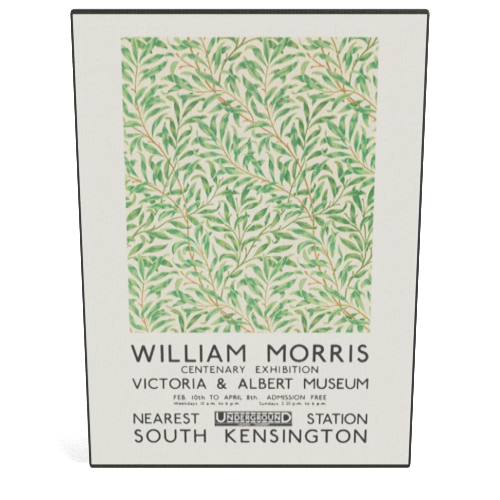

------------------------------------------------------------
추천 5순위 : 미드 센츄리 모던 전시 포스터/11 Mondrian - Compo 1930


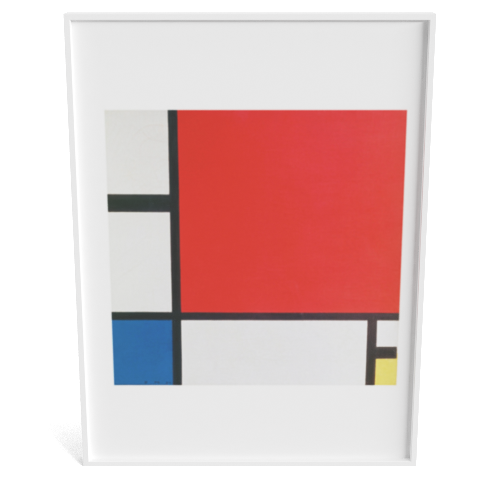

------------------------------------------------------------
추천 6순위 : BENKU 1인소파 고무나무 8074.9437 (내추럴베이지)


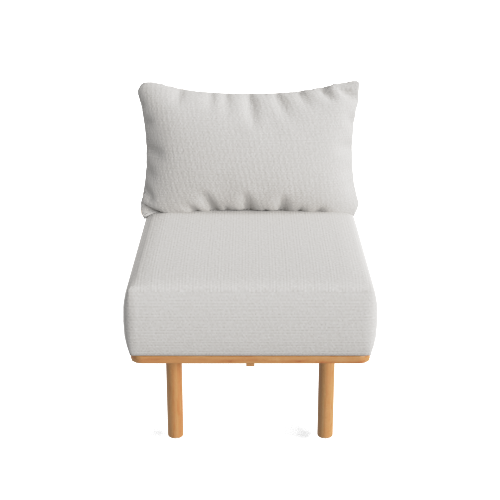

------------------------------------------------------------
추천 7순위 : 쉘체어 실버다리 (화이트)


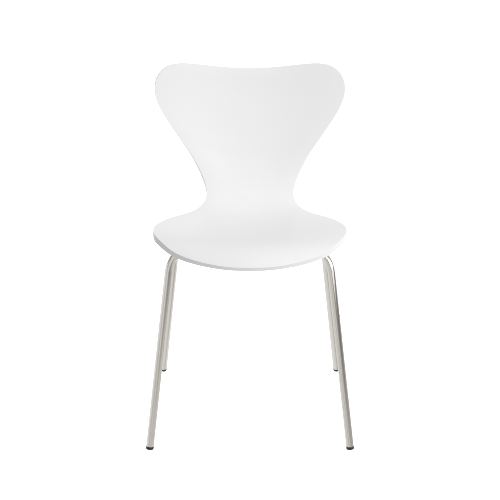

------------------------------------------------------------
추천 8순위 : 모듈 가구 1x2 사이드테이블 (그린)


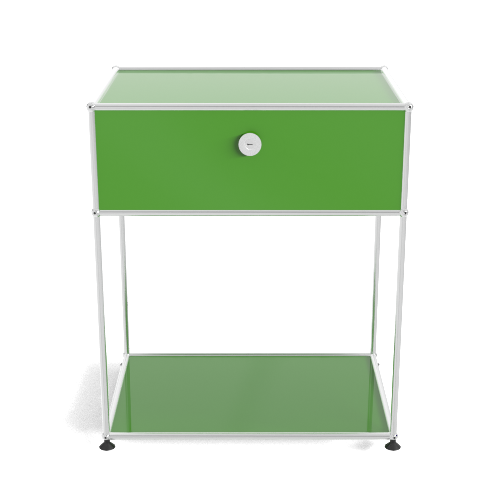

------------------------------------------------------------
추천 9순위 : LG 휘센 타워에어컨 FQ18PBNBP2 2in1 스페셜 (카밍베이지)(스탠드)


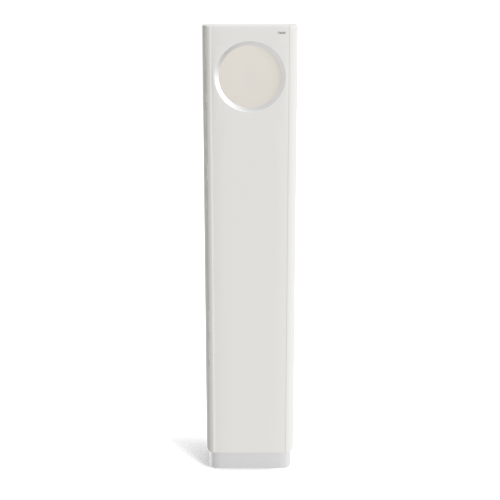

------------------------------------------------------------
추천 10순위 : 올 뉴탐 1인 패브릭소파 8colors (베이지+월넛)


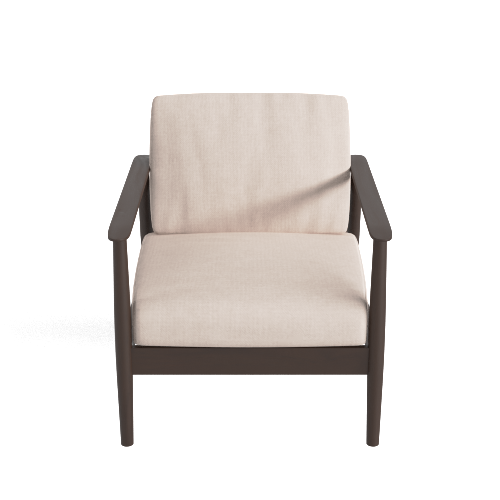

------------------------------------------------------------
추천 11순위 : 리노 2인용 아쿠아텍스 디자인소파 3colors (코발트블루)


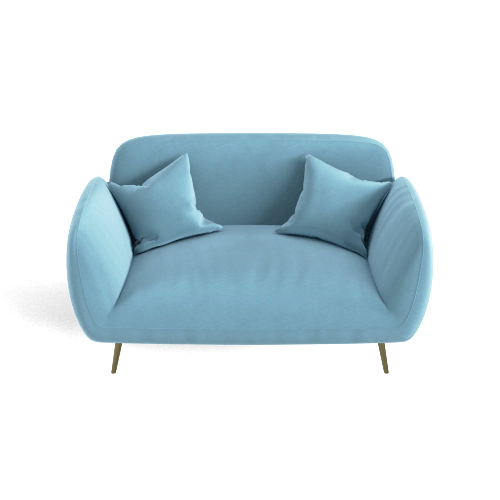

------------------------------------------------------------
추천 12순위 : 까페 2인 패브릭소파 7colors 다크블루


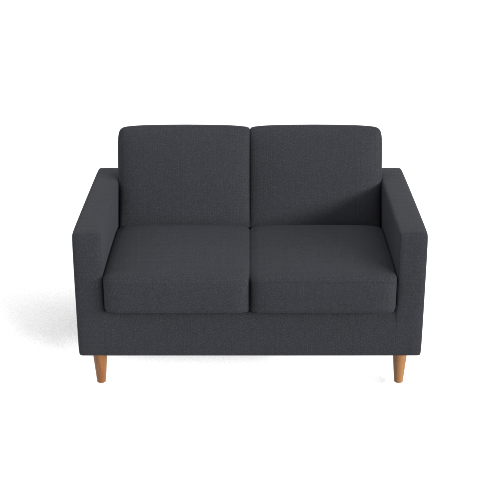

------------------------------------------------------------
추천 13순위 : 베니스 4인용 아쿠아 클린 텍스 패브릭 소파 (오션블루)


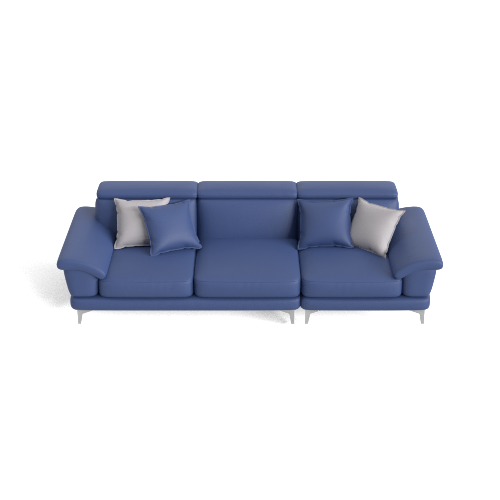

------------------------------------------------------------
추천 14순위 : 비하르 4인용 와이드 소파 드리밍 헤비 가죽 (파우더)


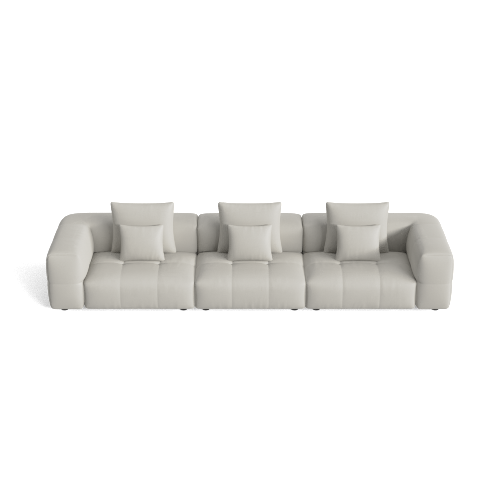

------------------------------------------------------------


In [13]:
import json
import pandas as pd
import numpy as np
from numpy import inf
import requests
from io import BytesIO
from PIL import Image
from IPython.display import display
import textdistance
import time
import random
from glob import glob
from sklearn.metrics import classification_report, average_precision_score
from sklearn.model_selection import train_test_split
import os
from preprocess import Preprocess
from run import SEARCH_RECOMMEND


base_bath = '2022-03-14/'

# abs path -> 22-03-07/ *.json
best = glob(base_bath+'best*.json')
item = glob(base_bath+'item*.json')
products = glob(base_bath+'products*.json')
#category1 == category2 = True
category = glob(base_bath+'categories.json')

DATA = Preprocess(best, item, products, category)

best_item_df, products_df_4, products_df_b = DATA.best_item, DATA.products_4, DATA.products_b

## 검색한 결과 show images
def show_result_and_image(df, prod, result_df, topn):
    # show result image
    print(f'사용자가 선택한 아이템 : {prod}')
    try:
        prod_res = requests.get(df[df['name'] == prod]['images'].values[0][0])
        display(Image.open(BytesIO(prod_res.content)))
    except:
        print('이미지 없음\n')
        print()

    print("="*80)
    print(f"추천 아이템 Top{topn}")
    print("="*80)

    i = 1
    for name, img_url in result_df[['name', 'images']].values:
        print(f"추천 {i}순위 : {name}")
        try:
            res = requests.get(img_url[0])
            img = Image.open(BytesIO(res.content))
            display(img)
        except:
            print('이미지 없음\n')
        print("-"*60)
        i += 1
        
def run_search(ent_id, prod_name):
    """
    ent_id : 0 -> '421B6D0E746C4E6D', 1 -> 'B57D4F97C0E44A11'
    prod_name : 검색할 상품 이름
    """
    data = [products_df_4, products_df_b]
    topn = [10, 14]
    search_engine = SEARCH_RECOMMEND(data[ent_id], qval=None)
    rec_report = search_engine.search_product(prod_name, topn=topn[ent_id], algo='sorensen', 
                                             save_image=False, 
                                             verbose=False)
    
    rec_report_df = pd.DataFrame(rec_report, index=['사용자가 선택한 상품 ID', 
                                                '사용자가 선택한 상품', 
                                                '사용자가 선택한 상품이 해당한 Project Id', 
                                                '추천된 아이템', 
                                                '추천된 아이템 ID', 
                                                '추천된 아이템이 해당한 Project Id', 
                                                '사용자가 선택한 아이템-추천된 아이템 유사도']).T

    show_result_and_image(data[ent_id], prod_name, search_engine.result, topn[ent_id])
    
    return search_engine.result, search_engine.project_id
# enterpriseID = 0 -> 4 제품 , 1 -> B 제품
# prod = 검색하고 싶은 상품 이름입력

prod = '카메론 3인용 스타일클린 워셔블 패브릭소파'
result, project_id = run_search(ent_id=1, prod_name=prod)

## 모델의 다양성 및 전문가 데이터 기반 평갸지표

In [14]:
def average(result, project_id,products_df, number):
    results = []
    for i in range(len(project_id)):
        # products_df에서 검색한 프로젝트 아이디를 찾고 프로젝트 아이디가 가지고 있는 아이템들을 list로 가져오기
        project_products_id = products_df[products_df['projectId'] == project_id[i]]['product_id'].tolist()
        #result(추천해준 제품들) 리스트 업
        result_product_id = result['product_id'].tolist()
        for j in range(len(result_product_id)):
            # 해당 제품의 프로젝트 아이디가 가지고 있는 아이템 중 추천한 아이템이 들어있는가 
            if result_product_id[j] in project_products_id:
                # 들어있으면 1
                result_product_id[j] = 1
            else:
                # 없으면 0
                result_product_id[j] = 0
        results.append(result_product_id)

    total = []
    for res in results:
        total.append(sum(res) / len(res))
    
    total = sorted(total, reverse=True)[:5]
    print(f'Top {number} 해당해는 비율')
    for num, i in enumerate(total):
        print(f'{num+1}선택한 프로젝트 아이템이 들어있는 비율 : {round(i, 3)}  다른 프로젝트 아이템이 들어있는 비율 : {round(1 - i, 3)}')
        
    
# def sparse_matrix(products_df, result):
    # project 마다 item별 awesome_score 를 값으로 줘서 값이 존재하면 1 존재하지않으면 0
    if products_df['enterpriseId'][0] == 'B57D4F97C0E44A11':
        train = products_df.pivot_table('awesome_score', index='category', columns='projectId').fillna(0).round().astype(int).T

        #나눠준 프로젝트마다 describe를 진행해 카테고리 별 몇개의 아이템을 사용했는지 평균을 구함 code -> x_train.describe().T['mean']
        # 그 평균을 np.percentile을 진행해서 mean 값들의 70%에 해당하는 값보다 크면 1 작으면 0 으로 
        # 가장 많이 등장하는 아이템들로 target을 선정 = code -> .apply(lambda x: 1 if x > np.percentile(x_train.describe().T['mean'], 50) else 0).reset_index(drop='name_x')
        train = train.describe().T['mean'].apply(lambda x: 1 if x > np.percentile(train.describe().T['mean'], 50) else 0).reset_index(drop='name_x')

        # 새로운 프레임(columns=category)
        frame = pd.DataFrame(columns=products_df.pivot_table('awesome_score',
                                                           index='category',
                                                            columns='projectId').fillna(0).round().astype(int).T.columns,index=['user']).fillna(0)
        # 추천 해준 category 이름으로 unique 적용
        # 추천 해준 아이템 카테고리가 frame 존재 하면 1 없으면 0
        for i in result['category'].unique().tolist():
            if i in frame.columns:
                frame[i] = 1
            else:
                0
        print()
        # 예측 된 값과 추천 해준 값을 비교 
        print('전문가 셋 데이터 비교평가')
        
        print(classification_report(frame.iloc[0].values, train.values))
        
        ap = average_precision_score(frame.iloc[0].values, train.values)
        # Average_precision이 높으면 가장 많은 카테고리를 추천 해주기에 50%대가 적절함
        print('Average_Precision : ',average_precision_score(frame.iloc[0].values, train.values))
        print('')
        # print( f'전문가   아이템 :{train.values}'),print(f'추천해준 아이템 :{frame.iloc[0].values}')
        
        frame.loc['전문가 아이템'] = train.values
        return frame, ap
    else:
        train = products_df.pivot_table('awesome_score', index='category', columns='projectId').fillna(0).round().astype(int).T

        #나눠준 프로젝트마다 describe를 진행해 카테고리 별 몇개의 아이템을 사용했는지 평균을 구함 code -> x_train.describe().T['mean']
        # 그 평균을 np.percentile을 진행해서 mean 값들의 70%에 해당하는 값보다 크면 1 작으면 0 으로 
        # 가장 많이 등장하는 아이템들로 target을 선정 = code -> .apply(lambda x: 1 if x > np.percentile(x_train.describe().T['mean'], 50) else 0).reset_index(drop='name_x')
        train = train.describe().T['mean'].apply(lambda x: 1 if x > np.percentile(train.describe().T['mean'], 50) else 0).reset_index(drop='name_x')

        # 새로운 프레임(columns=category)
        frame = pd.DataFrame(columns=products_df.pivot_table('awesome_score',
                                                           index='category',
                                                            columns='projectId').fillna(0).round().astype(int).T.columns,index=['user']).fillna(0)
        # 추천 해준 category 이름으로 unique 적용
        # 추천 해준 아이템 카테고리가 frame 존재 하면 1 없으면 0
        for i in result['category'].unique().tolist():
            if i in frame.columns:
                frame[i] = 1
            else:
                0
        print()
        # 예측 된 값과 추천 해준 값을 비교 
        print('전문가 셋 데이터 비교평가')
        # 예측 된 값과 추천 해준 값을 비교 
        print(classification_report(frame.iloc[0].values, train.values))
        
        ap = average_precision_score(frame.iloc[0].values, train.values)
        # Average_precision이 높으면 가장 많은 카테고리를 추천 해주기에 50%대가 적절함
        print('Average_Precision : ',average_precision_score(frame.iloc[0].values, train.values))
        print('')
        # print( f'전문가   아이템 :{train.values}'),print(f'추천해준 아이템 :{frame.iloc[0].values}')
        return frame, ap
result_frame, average_precision  = average(result, project_id, products_df_b, 5)

Top 5 해당해는 비율
1선택한 프로젝트 아이템이 들어있는 비율 : 0.643  다른 프로젝트 아이템이 들어있는 비율 : 0.357
2선택한 프로젝트 아이템이 들어있는 비율 : 0.214  다른 프로젝트 아이템이 들어있는 비율 : 0.786
3선택한 프로젝트 아이템이 들어있는 비율 : 0.214  다른 프로젝트 아이템이 들어있는 비율 : 0.786
4선택한 프로젝트 아이템이 들어있는 비율 : 0.214  다른 프로젝트 아이템이 들어있는 비율 : 0.786
5선택한 프로젝트 아이템이 들어있는 비율 : 0.214  다른 프로젝트 아이템이 들어있는 비율 : 0.786

전문가 셋 데이터 비교평가
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        11
           1       0.78      1.00      0.88         7

    accuracy                           0.89        18
   macro avg       0.89      0.91      0.89        18
weighted avg       0.91      0.89      0.89        18

Average_Precision :  0.7777777777777778



In [15]:
result_frame

category,가전,드레스룸/행거,문/창문,반려동물,생활/운동,소파,수납가구,유아동가구,의자/스툴,조명,주방싱크/욕실,책상/테이블,책장/선반,침대/매트리스,파티션/구조물,패브릭,홈데코,화장대/거울
user,1,0,0,0,0,1,0,0,1,1,0,1,0,0,0,1,1,0
전문가 아이템,1,0,0,0,0,1,1,0,1,1,0,1,1,0,0,1,1,0


In [16]:
print('average_precision : ',average_precision)

average_precision :  0.7777777777777778
